In [83]:
import pandas as pd
import datetime
from collections import Counter
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [84]:
tr_1 = pd.read_csv("../data/raw/transactions_1.csv", index_col=0)
tr_2 = pd.read_csv("../data/raw/transactions_2.csv", index_col=0)

### Preprocessing

In [85]:
tr_1.shape, tr_2.shape

((500000, 3), (475955, 3))

In [86]:
tr1_products = tr_1["product_id"].unique()
tr2_products = tr_2["product_id"].unique()
print(set(tr2_products).difference(set(tr1_products)))
print(set(tr1_products).difference(set(tr2_products)))

{'Oxygen', 'Equipe', 'MCC/Smart'}
set()


**The test set tr_2** contains 3 new products compared to **traning set tr_1**

In [87]:
tr_total = pd.concat([tr_1, tr_2], axis = 0).sort_values(by = ["date"])
tr_total.isna().sum(axis = 0)

customer_id    0
product_id     0
date           0
dtype: int64

In [88]:
# convert date column to datetime
tr_total['date'] = pd.to_datetime(tr_total['date'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')

tr_total['year'] = tr_total['date'].dt.to_period('Y') # Format: YYYY
tr_total['year_month'] = tr_total['date'].dt.to_period('M')  # Format: YYYY-MM
tr_total['year_month_day'] = tr_total['date'].dt.to_period('D')  # Format: YYYY-MM-DD
tr_total['year_month_day_hour'] = tr_total['date'].dt.to_period('h')  # Format: YYYY-MM-DD HH

In [89]:
tr_total.head()

,customer_id,product_id,date,year,year_month,year_month_day,year_month_day_hour
657826,1435072,Peugeot,2017-01-01 08:32:26.307,2017,2017-01,2017-01-01,2017-01-01 08:00
658033,1435072,Fiat,2017-01-01 08:38:15.207,2017,2017-01,2017-01-01,2017-01-01 08:00
755034,4104271,Peugeot,2017-01-01 11:29:18.527,2017,2017-01,2017-01-01,2017-01-01 11:00
755319,4104271,Abarth,2017-01-01 11:59:30.613,2017,2017-01,2017-01-01,2017-01-01 11:00
659733,3944257,Abarth,2017-01-01 15:22:46.793,2017,2017-01,2017-01-01,2017-01-01 15:00


### Analytics

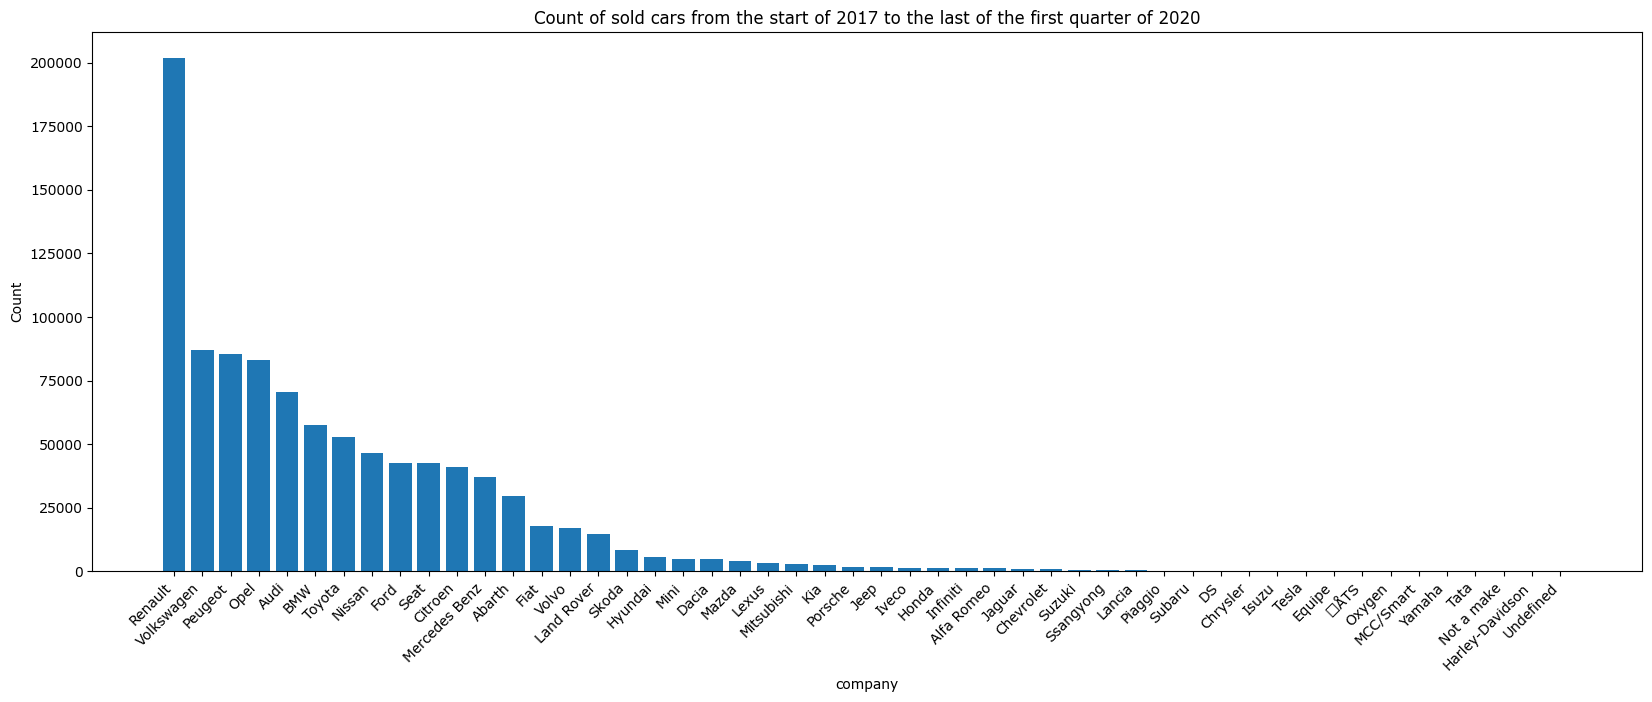

In [90]:
products =  Counter(tr_total["product_id"])
sorted_products = dict(sorted(list(products.items()), key = lambda x : x[1], reverse = True))

fig = plt.figure(figsize=(20, 7))
plt.bar(sorted_products.keys(), sorted_products.values());

plt.xticks(rotation=45, ha='right')

plt.xlabel("company")
plt.ylabel("Count")
plt.title("Count of sold cars from the start of 2017 to the last of the first quarter of 2020")
plt.show()

In [91]:
tr_total.head()

,customer_id,product_id,date,year,year_month,year_month_day,year_month_day_hour
657826,1435072,Peugeot,2017-01-01 08:32:26.307,2017,2017-01,2017-01-01,2017-01-01 08:00
658033,1435072,Fiat,2017-01-01 08:38:15.207,2017,2017-01,2017-01-01,2017-01-01 08:00
755034,4104271,Peugeot,2017-01-01 11:29:18.527,2017,2017-01,2017-01-01,2017-01-01 11:00
755319,4104271,Abarth,2017-01-01 11:59:30.613,2017,2017-01,2017-01-01,2017-01-01 11:00
659733,3944257,Abarth,2017-01-01 15:22:46.793,2017,2017-01,2017-01-01,2017-01-01 15:00


In [92]:
def plot_product_count(agg_fct = "count", ascending = False, size = (20, 7)) :
    """Function to generate plot of number of products per customer in a periodic way

    Args:
        ascending (bool, optional): sorted by ascending order. Defaults to False.
        agg_fct (str, optional): aggregation function. Defaults to "count".
        size (tuple, optional): size of figure. Defaults to (20, 7).
    """
    tr_total_per_customer_per_period = tr_total[["customer_id", "product_id"]].groupby(["customer_id"], axis = 0).agg(agg_fct)
        
    cutomer_to_count = tr_total_per_customer_per_period.sort_values(by = "product_id", ascending = ascending).to_dict()["product_id"]
    print(f"Customers with most product {agg_fct} : ", list(cutomer_to_count.keys())[:10])
    customer_idx, counts = [i for i in range(len(cutomer_to_count.keys()))], cutomer_to_count.values()

    fig = plt.figure(figsize = size)
    plt.bar(customer_idx, counts);
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Customer")
    plt.ylabel(agg_fct)
    plt.title(f"{agg_fct} of transactions for each customer")
    plt.show()

Customers with most product count :  [8649525, 1242611, 9467115, 1618902, 1435341, 5741989, 8423804, 4893343, 6026638, 5102428]


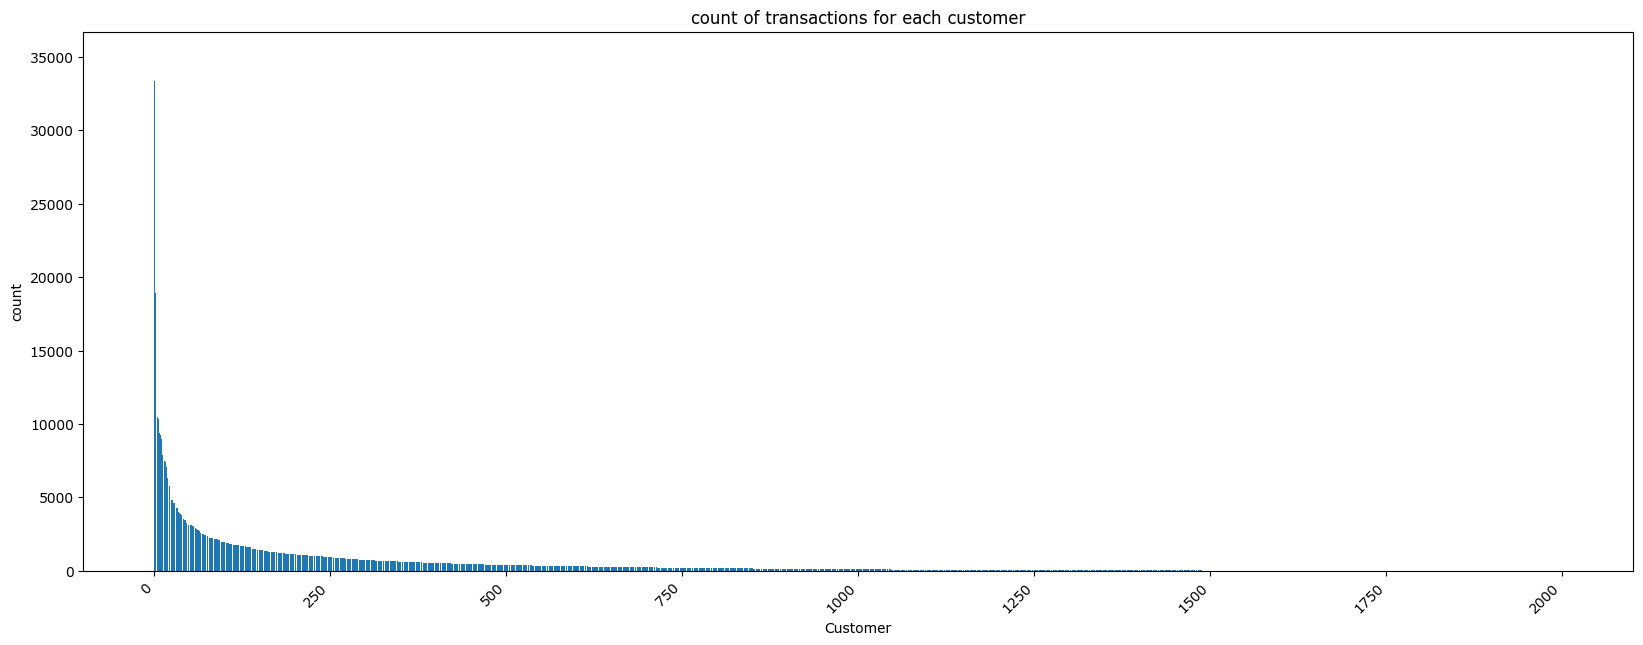

In [93]:
plot_product_count()

Customers with most product nunique :  [1242611, 4893343, 1618902, 9318538, 5102428, 1067115, 9467115, 8649525, 2688067, 2147563]


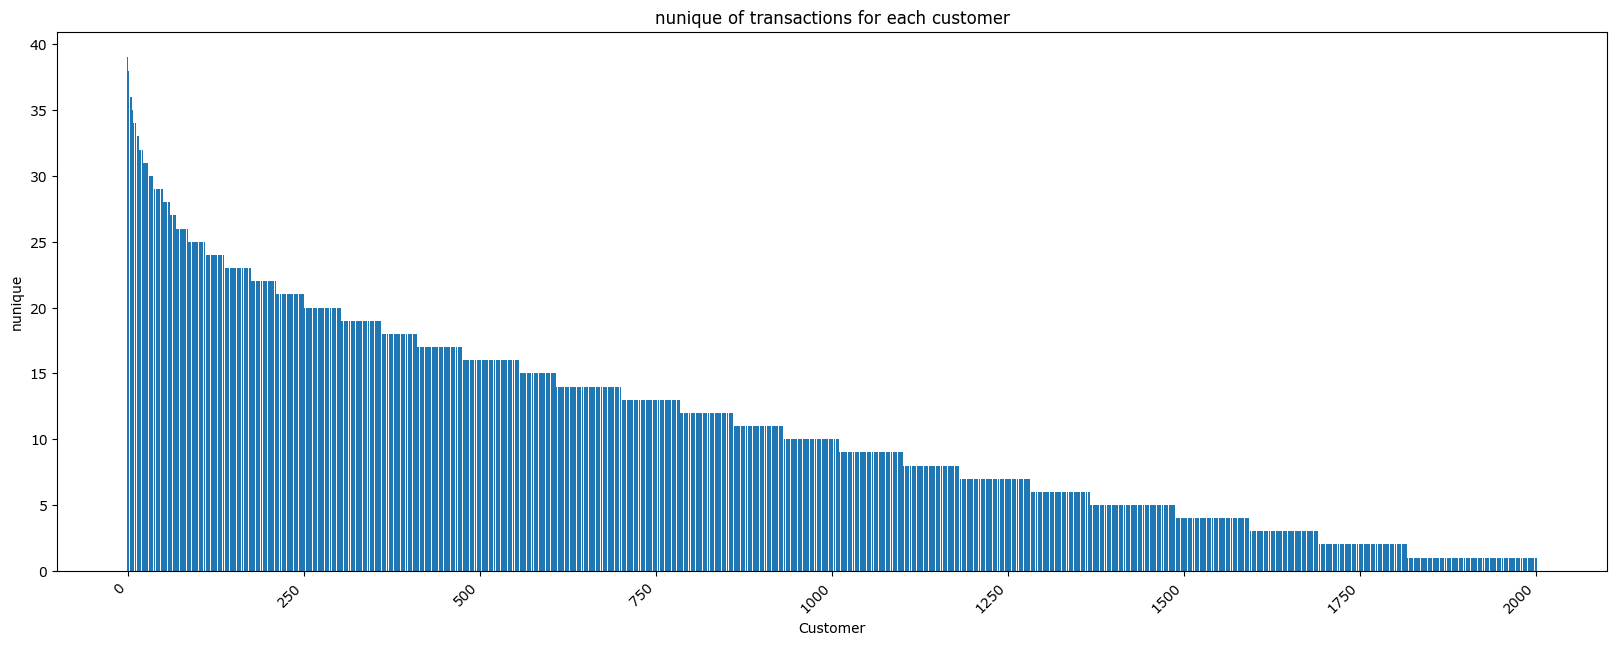

In [94]:
plot_product_count(agg_fct = "nunique")

* High variability in number of sold products
* Few customers with > 30000 transactions, others with less than 10000
* High transaction customers make transaction on a variety of products

Let's look at the transaction per year, month, day for the customers with highest number of transactions 8649525 and another one with way less transactions such as 5102428

In [95]:
def plot_product_count_per_customer(customer_id, granularity = "year", size = (20, 7)) :
    """Function to generate plot of number of products per customer in a periodic way

    Args:
        customer_id (str, optional): id of customer.
        size (tuple, optional): size of figure. Defaults to (20, 7).
    """
    grouped_data = []
    granularity_tab = ["year", "year_month"]
    agg_fct_tab = ["count", "nunique"]
    for granularity in granularity_tab :
        temp_data = []
        for agg_fct in agg_fct_tab :
            date_to_count=tr_total[tr_total["customer_id"] == customer_id][[granularity, "product_id"]].groupby([granularity], axis = 0).agg(agg_fct).to_dict()["product_id"]
            dates, counts = date_to_count.keys(), date_to_count.values()
            
            if granularity == "year" :
                dates = [period.to_timestamp().year for period in dates]
            else :
                dates = [period.to_timestamp() for period in dates]
            temp_data.append((dates, counts))
        
        grouped_data.append(temp_data)
        
    
    fig, axes = plt.subplots(2, 2, figsize = size)
    
    for i, granularity in enumerate(granularity_tab) :
        for j, agg_fct in enumerate(agg_fct_tab) :
            
            axes[i][j].bar(grouped_data[i][j][0], grouped_data[i][j][1], color='skyblue')
            axes[i][j].plot(grouped_data[i][j][0], grouped_data[i][j][1])
            
            axes[i][j].set_xticks(grouped_data[i][j][0])
            axes[i][j].tick_params(axis='x', rotation=90)
            axes[i][j].set_xlabel("Date")
            axes[i][j].set_ylabel(agg_fct)
            axes[i][j].set_title(f"{granularity} {agg_fct} of transactions for customer {customer_id}")
    
    plt.tight_layout()
    plt.show()

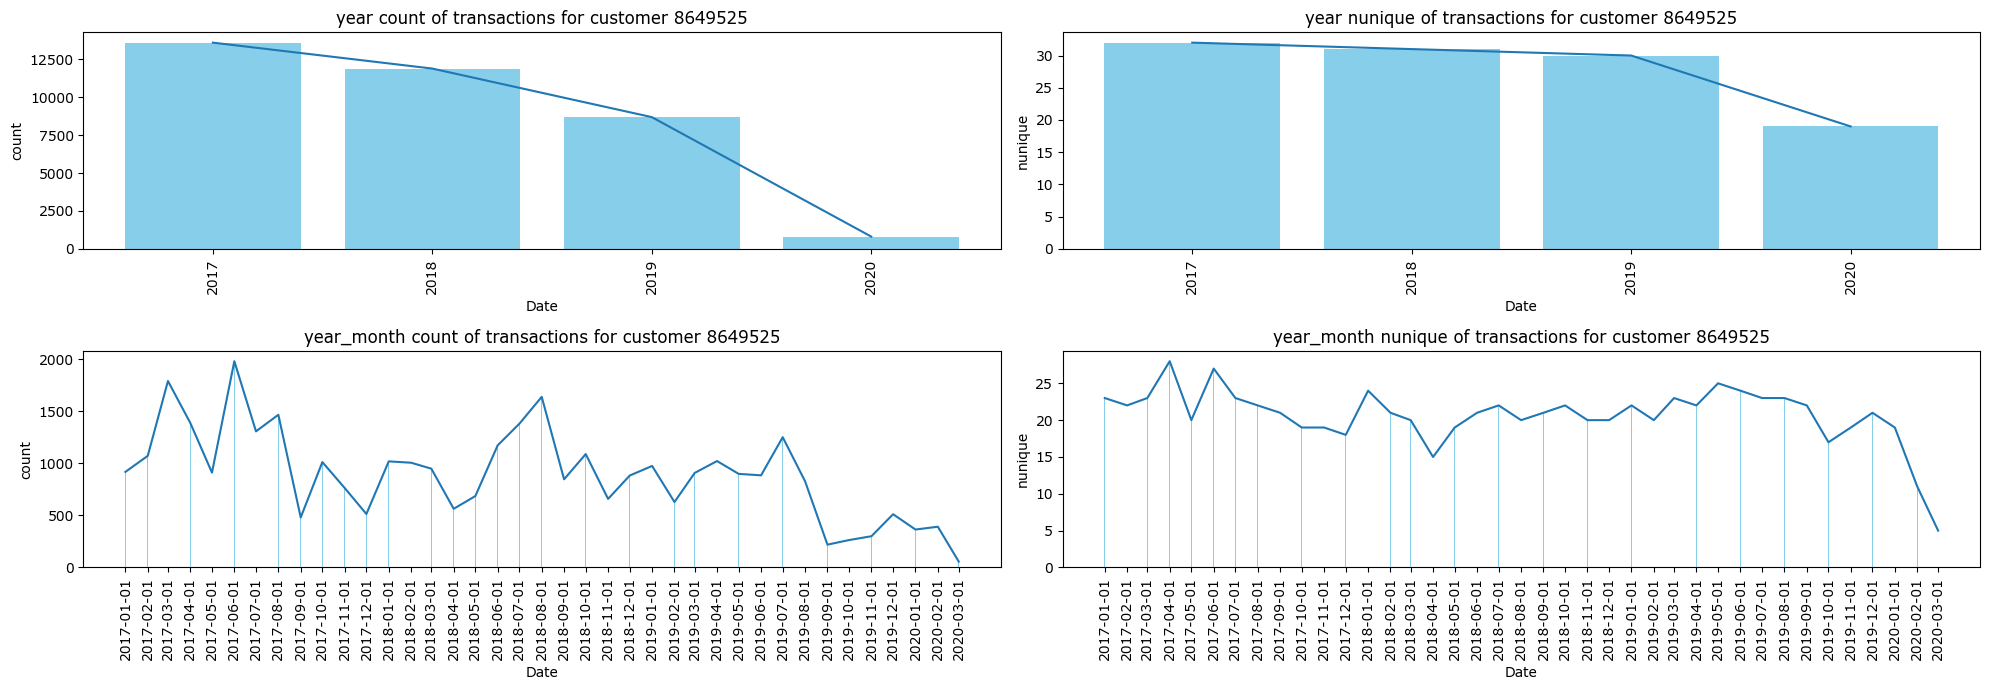

In [96]:
plot_product_count_per_customer(8649525)

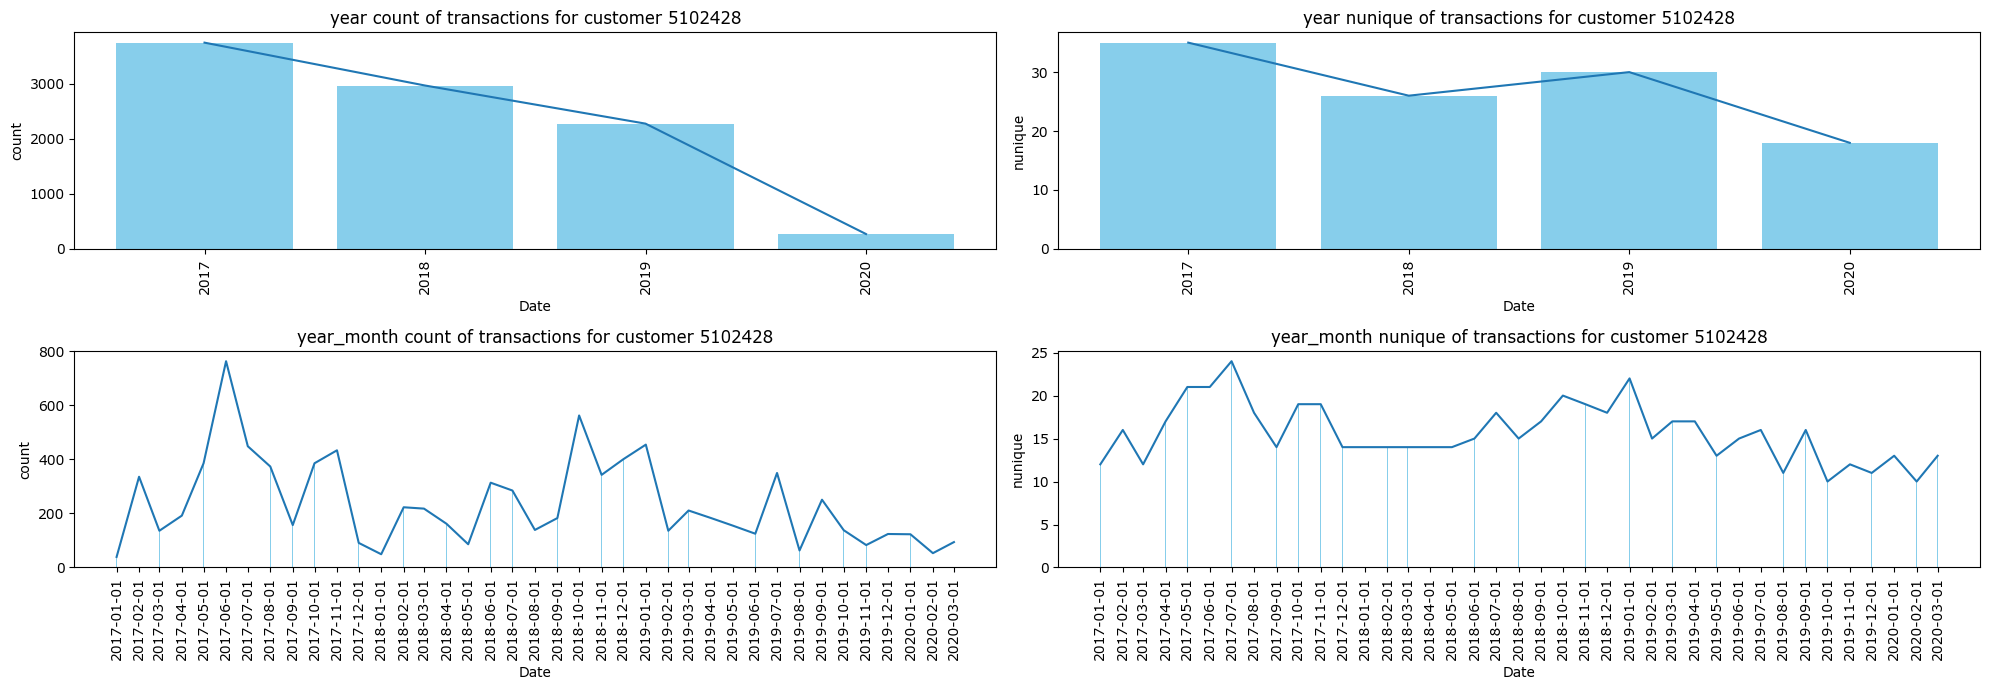

In [97]:
plot_product_count_per_customer(5102428)

* The number of transactions vary a lot depending on the month and year.
* We notice for both customers a decrease in the number of unique products involved in their transactions especially in 2020 for customer 8649525.

Now, let's look at the the frequency of transactions per product. Let's take a closer look at the products with the highest number of transactions Renault and Volkswagen.

In [98]:
def plot_product_count_per_customer(product_name, granularity = "year", size = (20, 14)) :
    """Function to generate plot of number of customers for each product
    It also plots the top 2 customers transactions on this product.
    The period is from 2017 to first quarted of 2020

    Args:
        product_name (str, optional): name of the product.
        size (tuple, optional): size of figure. Defaults to (20, 7).
    """
    grouped_data = []
    granularity_tab = ["year", "year_month"]
    agg_fct_tab = ["count", "nunique"]
    for granularity in granularity_tab :
        temp_data = []
        for agg_fct in agg_fct_tab :
            date_to_count=tr_total[tr_total["product_id"] == product_name][[granularity, "customer_id"]].groupby([granularity], axis = 0).agg(agg_fct).to_dict()["customer_id"]
            dates, counts = date_to_count.keys(), date_to_count.values()
            
            if granularity == "year" :
                dates = [period.to_timestamp().year for period in dates]
            else :
                dates = [period.to_timestamp() for period in dates]
            temp_data.append((dates, counts))
        
        grouped_data.append(temp_data)

    # plot the transaction variation for the customers with the most transaction on this product
    customers = list(tr_total[tr_total["product_id"] == "Renault"][["customer_id", "product_id"]].groupby(["customer_id"], axis = 0).agg("count").nlargest(5, "product_id").index[:2])
    temp_data = []
    for customer in customers :
        date_to_count = tr_total[(tr_total["product_id"] == product_name) & (tr_total["customer_id"] == customer)][[granularity, "customer_id"]].groupby([granularity], axis = 0).agg("count").to_dict()["customer_id"]
        dates, counts = date_to_count.keys(), date_to_count.values()
            
        if granularity == "year" :
            dates = [period.to_timestamp().year for period in dates]
        else :
            dates = [period.to_timestamp() for period in dates]
        temp_data.append((dates, counts))
        
    grouped_data.append(temp_data)
    fig, axes = plt.subplots(3, 2, figsize = size)
    
    for i, granularity in enumerate(granularity_tab) :
        for j, agg_fct in enumerate(agg_fct_tab) :
            
            axes[i][j].bar(grouped_data[i][j][0], grouped_data[i][j][1], color='skyblue')
            axes[i][j].plot(grouped_data[i][j][0], grouped_data[i][j][1])
            
            axes[i][j].set_xticks(grouped_data[i][j][0])
            axes[i][j].tick_params(axis='x', rotation=90)
            axes[i][j].set_xlabel("Date")
            axes[i][j].set_ylabel(agg_fct)
            axes[i][j].set_title(f"{granularity} {agg_fct} of transactions for {product_name}")
            
    for j, customer in enumerate(customers) :
            
        axes[-1][j].bar(grouped_data[-1][j][0], grouped_data[-1][j][1], color='skyblue')
        axes[-1][j].plot(grouped_data[-1][j][0], grouped_data[-1][j][1])
        
        axes[-1][j].set_xticks(grouped_data[-1][j][0])
        axes[-1][j].tick_params(axis='x', rotation=90)
        axes[-1][j].set_xlabel("Date")
        axes[-1][j].set_ylabel(agg_fct)
        axes[-1][j].set_title(f"Count of transactions top {j+1} customer of {product_name}: {customer}")
    
    
    plt.tight_layout()
    plt.show()

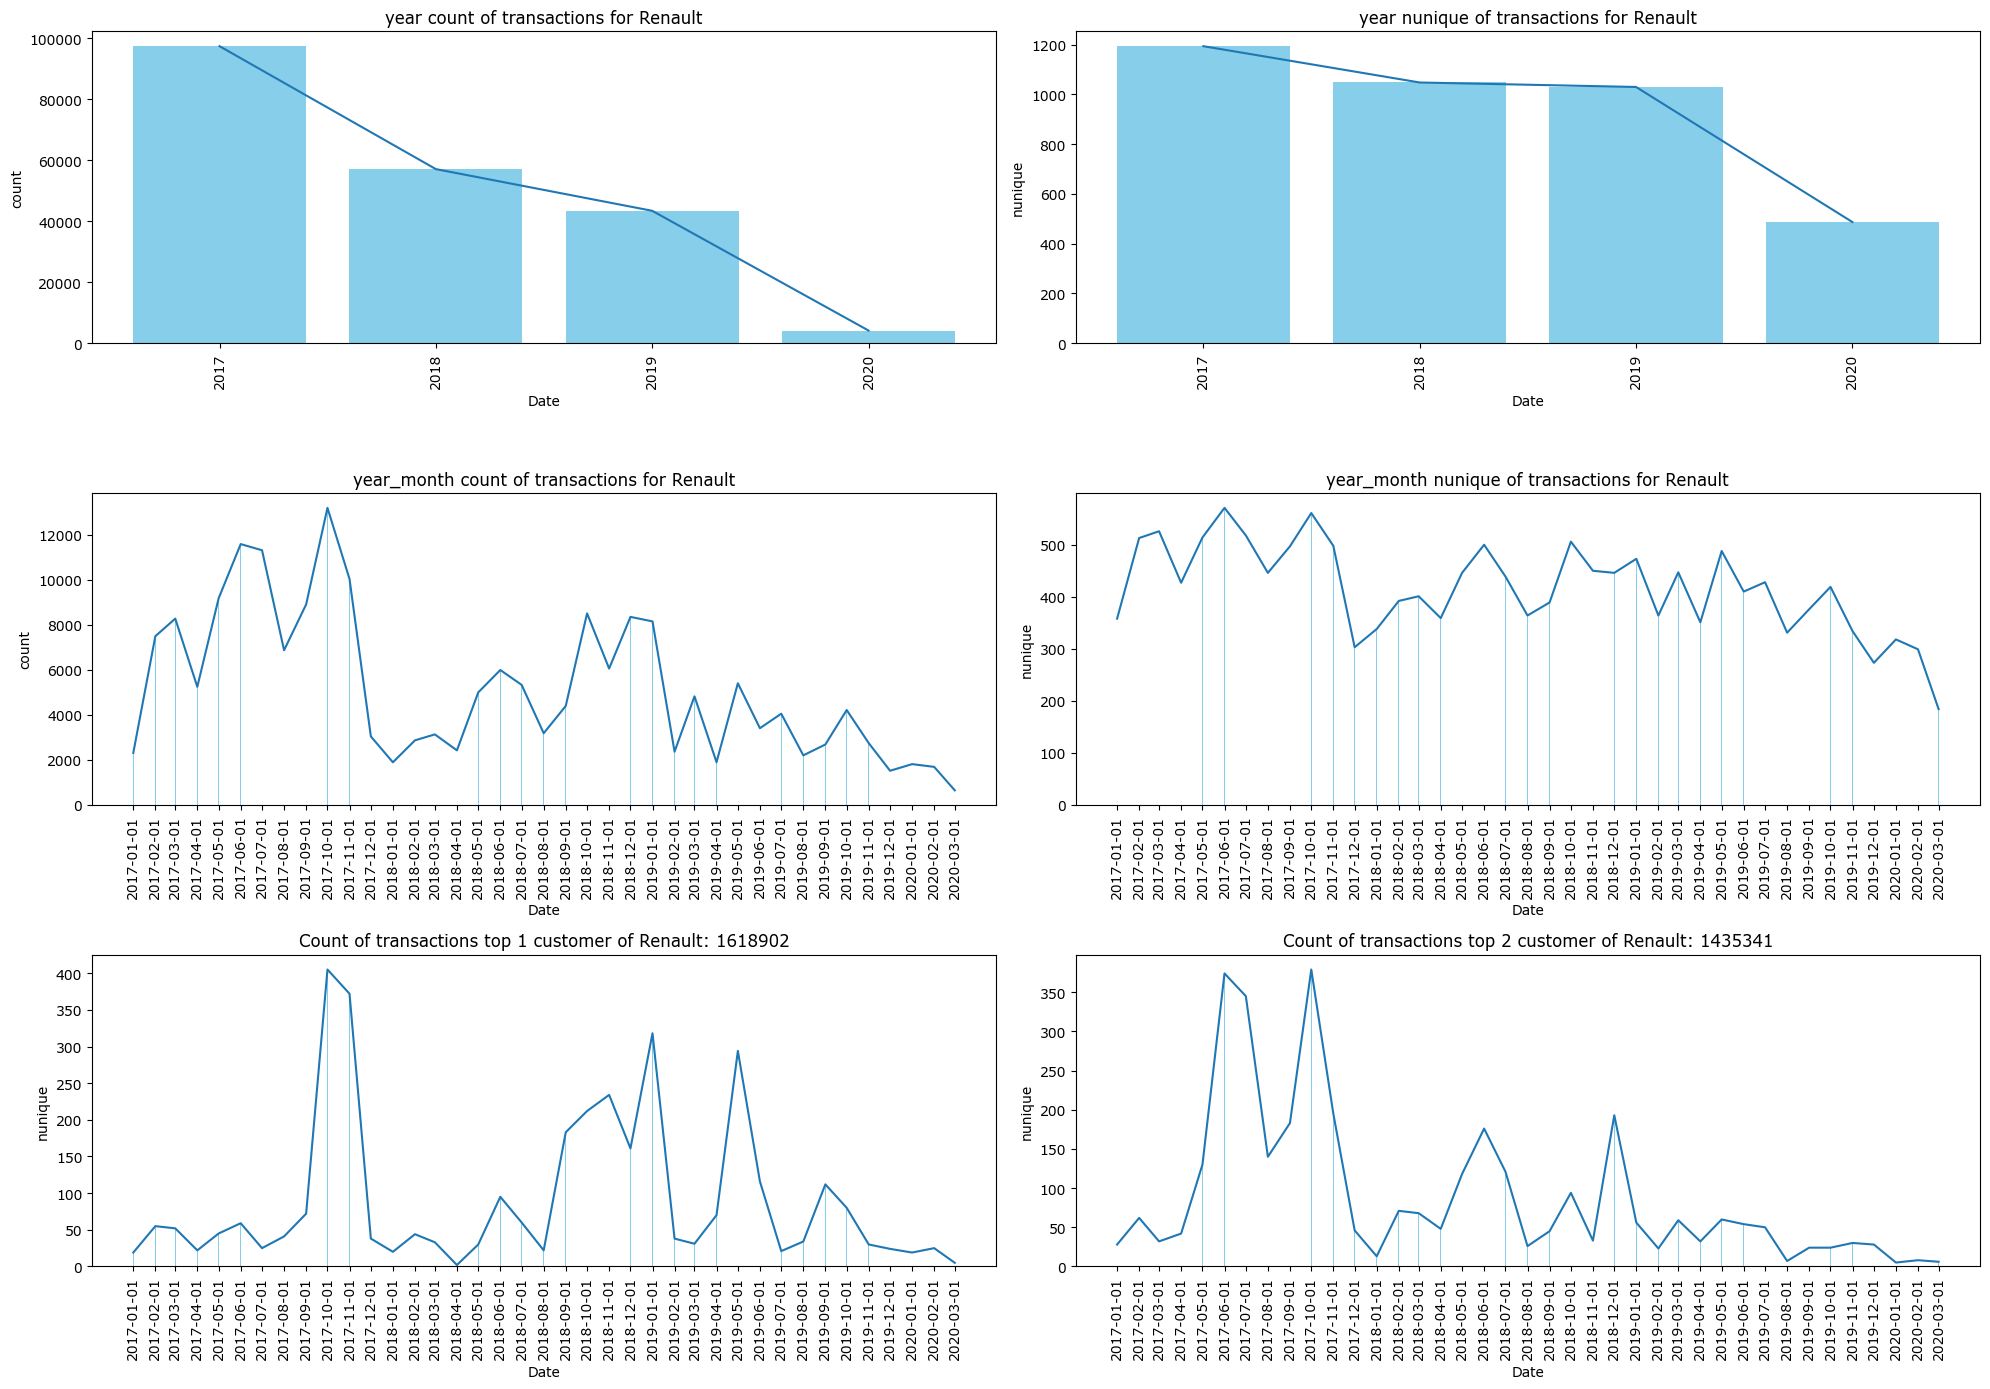

In [99]:
# 200k transactions total
plot_product_count_per_customer("Renault")

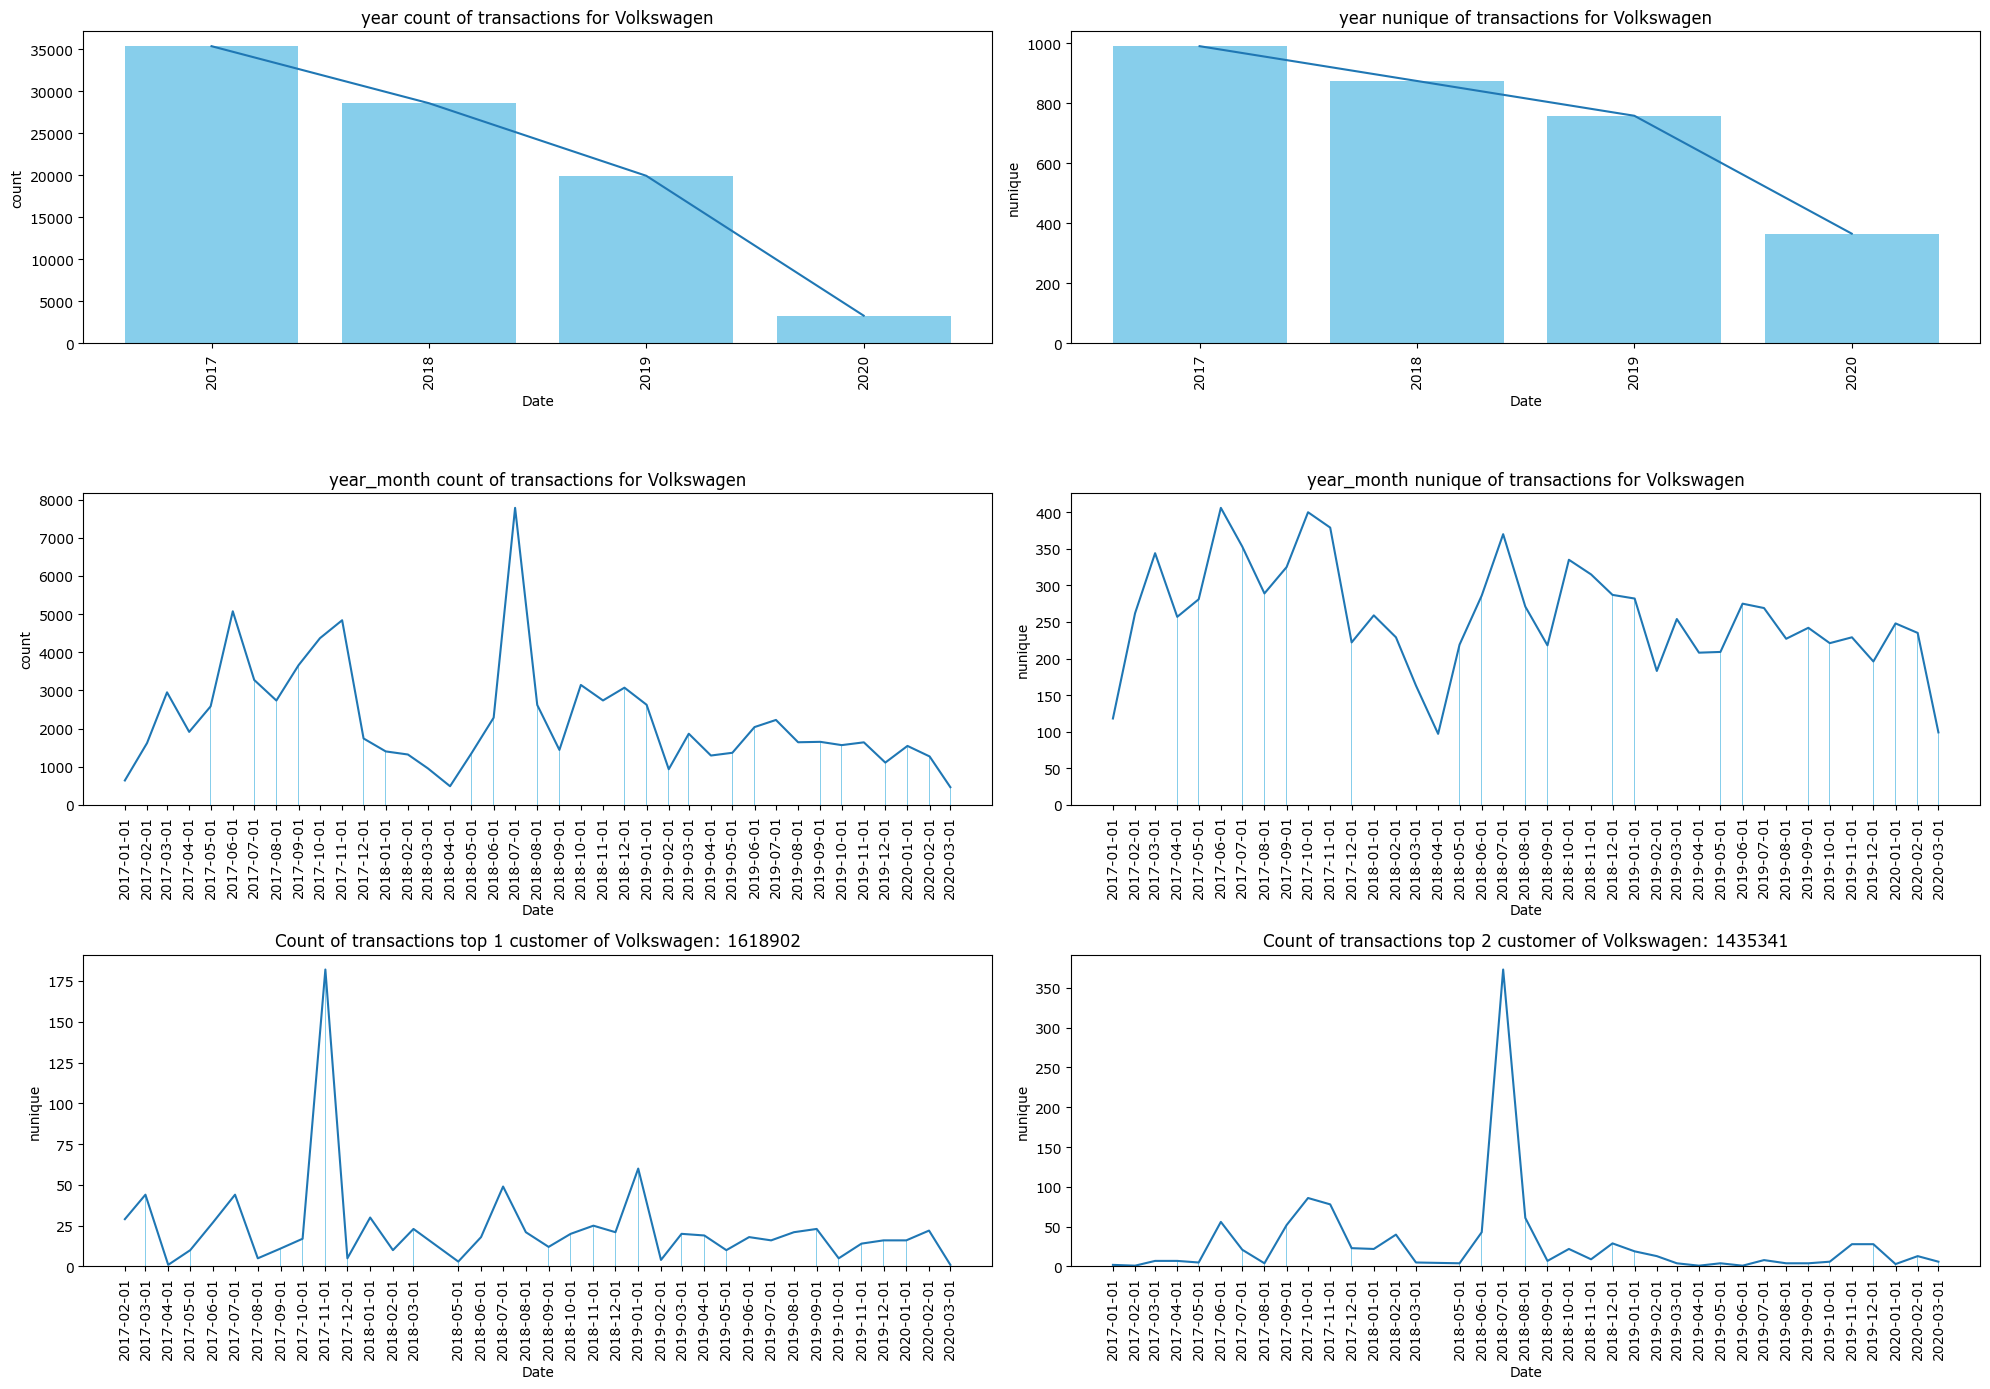

In [100]:
# 80k transactions in total
plot_product_count_per_customer("Volkswagen")

* Renault had a a huge decrease in the number of transactions and customers at the end of 2017.
* Volswagen had a resurgance of the number of transactions at july of 2018 as they acquired new customers, then a sharp dip immediately after.
* We notice that the transactions of customers are low on the majority of months with exception of few months that have the highest purchases. This is more apparent for Volswagen.

In [101]:
tr_total.head()

,customer_id,product_id,date,year,year_month,year_month_day,year_month_day_hour
657826,1435072,Peugeot,2017-01-01 08:32:26.307,2017,2017-01,2017-01-01,2017-01-01 08:00
658033,1435072,Fiat,2017-01-01 08:38:15.207,2017,2017-01,2017-01-01,2017-01-01 08:00
755034,4104271,Peugeot,2017-01-01 11:29:18.527,2017,2017-01,2017-01-01,2017-01-01 11:00
755319,4104271,Abarth,2017-01-01 11:59:30.613,2017,2017-01,2017-01-01,2017-01-01 11:00
659733,3944257,Abarth,2017-01-01 15:22:46.793,2017,2017-01,2017-01-01,2017-01-01 15:00


In [102]:
def get_top_products_last_6_months(df, window=6, sliding_window=3, top_k=5):
    
    df['date'] = pd.to_datetime(df['date'])
    # Add a sales count column (1 sale per row)
    df['sales'] = 1
    # Get the minimum and maximum dates in the dataset
    min_date = df['date'].min()
    max_date = df['date'].max()
    
    # Initialize an empty list to store results
    results = []
    top_products_set = set()  # To track the unique set of top products
    current_date = min_date + pd.DateOffset(months=window)
    
    while current_date <= max_date:
        six_months_ago = current_date - pd.DateOffset(months=window)
        window_data = df[(df['date'] > six_months_ago) & (df['date'] <= current_date)]
        
        # Aggregate sales by product
        product_sales = window_data.groupby('product_id')['sales'].sum().reset_index()
        
        # Rank products by sales
        product_sales['rank'] = product_sales['sales'].rank(method='dense', ascending=False)
        
        # Get the top 5 products
        top_sales = product_sales[product_sales['rank'] <= top_k].copy()
        top_sales['date'] = current_date
        top_products_set.update(top_sales['product_id'].unique())
        
        all_products_in_window = product_sales[['product_id', 'sales']].copy()
        all_products_in_window['date'] = current_date
        results.append(all_products_in_window)
        current_date += pd.DateOffset(months=sliding_window)
    
    all_products_df = pd.concat(results, ignore_index=True)
    pivot_table = all_products_df.pivot(index='date', columns='product_id', values='sales')
    
    # Keep only the unique products that appeared in the top 5 at any point
    pivot_table = pivot_table[list(top_products_set)]
    
    return pivot_table


def plot_seasonality(top_products_per_period):
    top_products_per_period.plot(figsize=(15, 7), marker='o')
    plt.title("Sales Trends of All Products (Seasonality Analysis)", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Sales Count", fontsize=12)
    
    # Ensure the index is datetime
    top_products_per_period.index = pd.to_datetime(top_products_per_period.index)
    # Get unique years from the dataset
    years = top_products_per_period.index.year.unique()
    # Determine the bounds of the data
    min_date = top_products_per_period.index.min()
    max_date = top_products_per_period.index.max()

    # Loop through the years and add lines only if within bounds
    for year in years:
        start_of_year = pd.to_datetime(f'{year}-01-01')
        if start_of_year >= min_date and start_of_year <= max_date:
            plt.axvline(x=start_of_year, color='black', linestyle='-', linewidth=2)
        
        for i in range(1, 5):  # There are 4 quarters in a year
            quarter_start = start_of_year + pd.DateOffset(months=3 * i)
            if quarter_start >= min_date and quarter_start <= max_date:
                plt.axvline(x=quarter_start, color='g', linestyle='-.', linewidth=1)
                # Label each quarter if within the data bounds
                if i == 1:
                    plt.text(quarter_start, 0, f"Q{i}", horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='green')
                else:
                    plt.text(quarter_start, 0, f"Q{i}", horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='green')
    # Add legend and grid
    plt.legend(title="Product ID", loc='upper left')
    plt.grid()
    plt.show()

In [103]:
top_products_per_period  = get_top_products_last_6_months(tr_total, sliding_window=2)

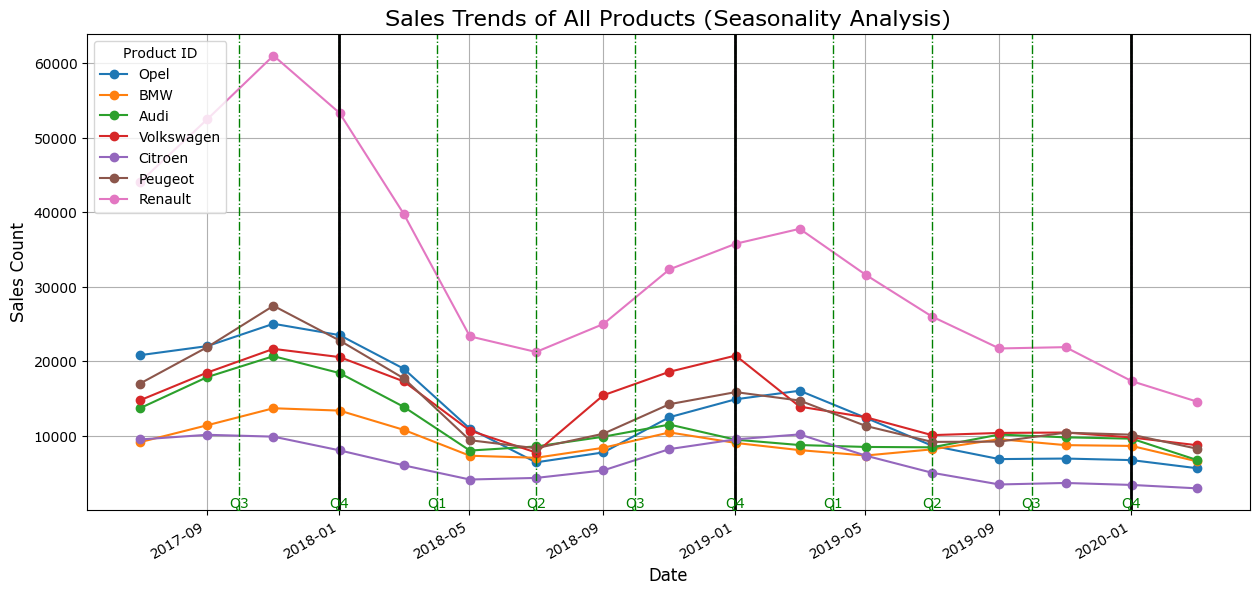

In [104]:
plot_seasonality(top_products_per_period)